In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Uniaxial_UC.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,...,Si,Mn,P,S,Ni,Cr,Cu,Method,Test Type,Dataset
0,1,400,25400,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
1,1,380,38800,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
2,1,380,48100,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
3,1,370,77200,600,825,0.05,0.03,0.0,20,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
4,1,370,152000,600,825,0.05,0.03,0.0,120,26,...,0.21,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,400,63000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
202,24,380,165000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
203,24,380,300000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4
204,24,360,1030000,600,660,0.06,0.00,0.0,120,19,...,0.26,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4


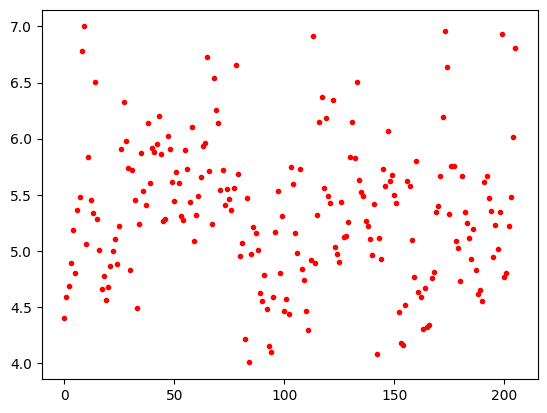

In [ ]:
# Scatter Plot of Target Column
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Dataset','Number of Cycles','Method'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# One-Hot encoding the "Test Type" column
features = pd.get_dummies(features, columns=['Test Type'], prefix='Test Type')

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Heat,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,Test Type_repeated,Test Type_reversed
0,9,490,600,1740,0.07,0.00,0.0,20,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,False,True
1,17,520,600,1750,0.07,0.00,0.0,20,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,False,True
2,10,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,False,True
3,10,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,False,True
4,18,520,600,1270,0.08,0.01,0.0,20,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,340,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,True,False
202,13,350,600,1740,0.07,0.00,0.0,120,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,True,False
203,24,360,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,True,False
204,21,365,600,1750,0.07,0.00,0.0,120,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,True,False


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
!pip install pyro-ppl

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

class BNN(PyroModule):
    def __init__(self, in_dim=20, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

# Coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.8 MB/s eta 0:00:00


Run # 1 Fold # 1


Sample: 100%|██████████| 200/200 [13:50,  4.15s/it, step size=4.89e-03, acc. prob=0.941]


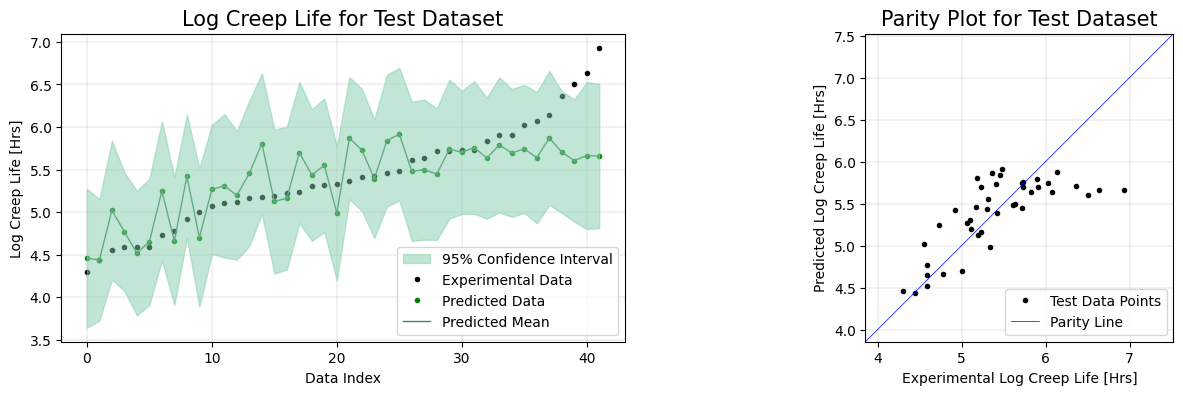

Pearson CC: 0.7388293746902503
R2 score: 0.5426366034280463
RMSE: 0.40664488486504685
MAE: 0.30218635476436684
MAPE: 0.05390976447080159
Coverage: 92.85714285714286
Upper coverage: 100.0
Lower coverage: 92.85714285714286
Average Interval Width: 1.5543584823608398
Median Interval Width: 1.5526833534240723
Composite Metric: 0.8574401514449892
********************
Run # 1 Fold # 2


Sample: 100%|██████████| 200/200 [14:10,  4.25s/it, step size=5.57e-03, acc. prob=0.906]


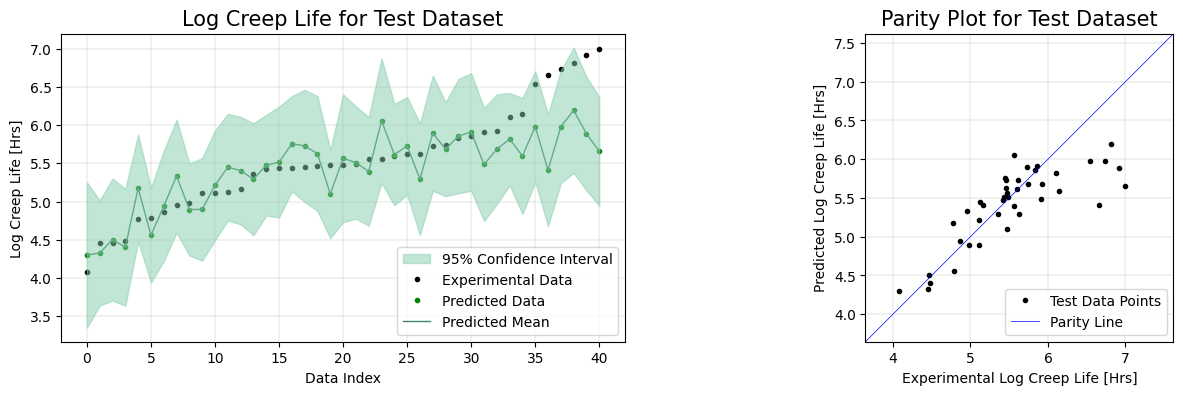

Pearson CC: 0.8002654635671771
R2 score: 0.5973455084655765
RMSE: 0.4343561714418083
MAE: 0.30285894118681767
MAPE: 0.05128129126968892
Coverage: 90.2439024390244
Upper coverage: 100.0
Lower coverage: 90.2439024390244
Average Interval Width: 1.4370479583740234
Median Interval Width: 1.4501543045043945
Composite Metric: 0.849224715607126
********************
Run # 1 Fold # 3


Sample: 100%|██████████| 200/200 [14:01,  4.21s/it, step size=4.29e-03, acc. prob=0.966]


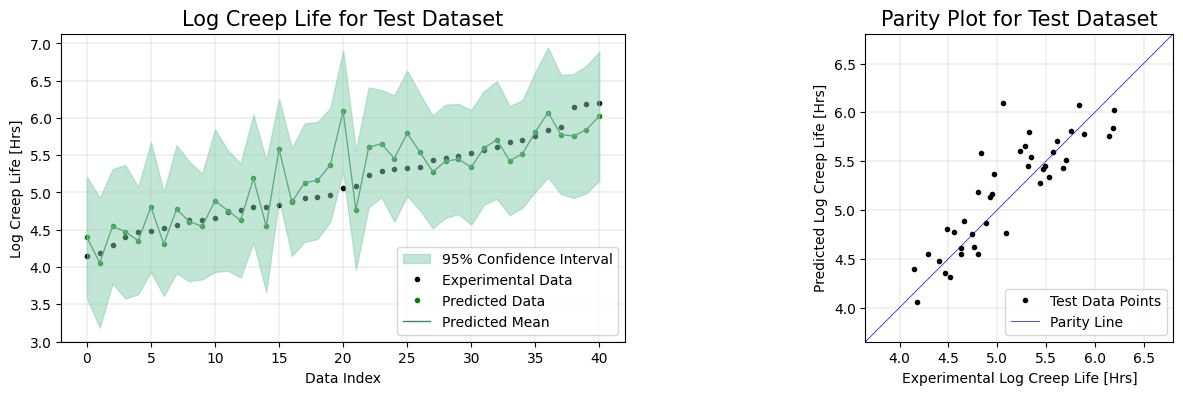

Pearson CC: 0.8605410846118693
R2 score: 0.70483046390473
RMSE: 0.3008170433256037
MAE: 0.23070175403816767
MAPE: 0.04552332735671415
Coverage: 95.1219512195122
Upper coverage: 95.1219512195122
Lower coverage: 100.0
Average Interval Width: 1.593140721321106
Median Interval Width: 1.5947303771972656
Composite Metric: 0.8701809462293748
********************
Run # 1 Fold # 4


Sample: 100%|██████████| 200/200 [14:03,  4.22s/it, step size=3.68e-03, acc. prob=0.977]


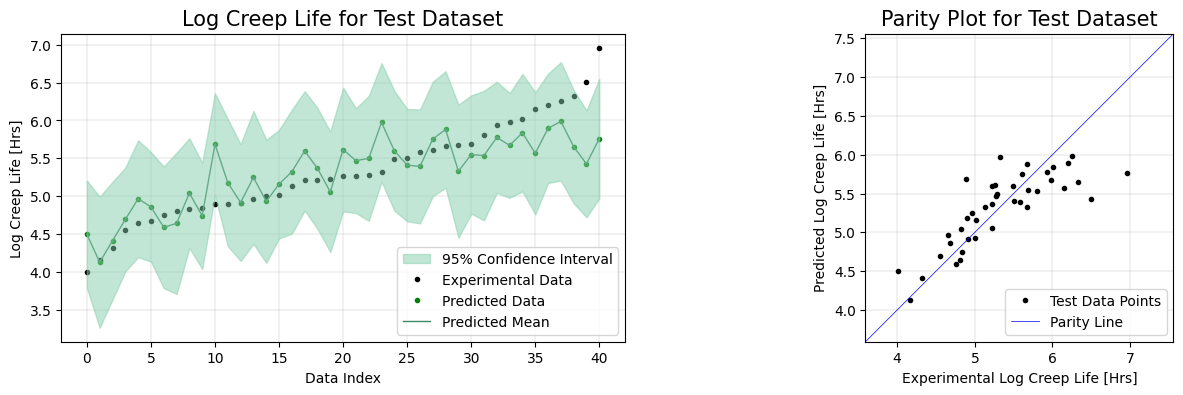

Pearson CC: 0.80184299253978
R2 score: 0.6341426561860922
RMSE: 0.39021367435946785
MAE: 0.2936023838565827
MAPE: 0.05337389097146992
Coverage: 92.6829268292683
Upper coverage: 97.5609756097561
Lower coverage: 95.1219512195122
Average Interval Width: 1.548683762550354
Median Interval Width: 1.552051305770874
Composite Metric: 0.8561991005833536
********************
Run # 1 Fold # 5


Sample: 100%|██████████| 200/200 [13:55,  4.18s/it, step size=4.70e-03, acc. prob=0.951]


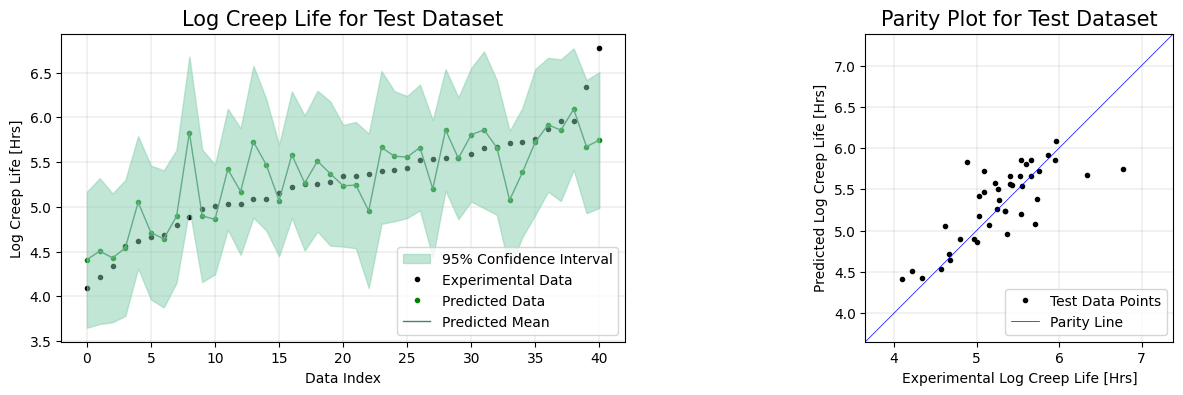

Pearson CC: 0.7713064991981662
R2 score: 0.5830298857532473
RMSE: 0.3474350870938499
MAE: 0.25014264026658123
MAPE: 0.0469225053705385
Coverage: 95.1219512195122
Upper coverage: 97.5609756097561
Lower coverage: 97.5609756097561
Average Interval Width: 1.4939463138580322
Median Interval Width: 1.4916906356811523
Composite Metric: 0.8810097064891012
********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            # define DNN
            model = BNN(hid_dim=10, n_hid_layers=3, prior_scale=1)
            nuts_kernel = NUTS(model, jit_compile=False)
            mcmc = MCMC(nuts_kernel, num_samples=100)
            mcmc.run(torch.Tensor(x_train), torch.Tensor(y_train.to_numpy()))

            # evaluate the model on test data
            predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
            preds = predictive(torch.Tensor(x_test))

            y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
            y_std = preds['obs'].T.detach().numpy().std(axis=1)

            ## Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            ## Parity Plot
            # find the boundaries of y_test and y_pred values
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            ax[1].plot(y_test, y_pred, 'ko', markersize=3, label="Test Data Points")
            ax[1].legend(loc=4, fontsize=10, frameon=False)
            ax[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            ax[1].legend(loc=4, fontsize=10, frameon=True)
            ax[1].set_xlabel("Experimental Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_ylabel("Predicted Log Creep Life [Hrs]", fontsize=10)
            ax[1].set_title("Parity Plot for Test Dataset", fontsize=15)
            ax[1].grid(True, which='major', linestyle='-', linewidth='0.25')
            ax[1].set_xlim(bounds)
            ax[1].set_ylim(bounds)
            ax[1].set_aspect("equal", adjustable="box") # Square aspect ratio
            plt.show()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))
            MAPE[j, i] = mean_absolute_percentage_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'MAPE: {MAPE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            # Prediction interval width
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'MAPE': MAPE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,MAPE
0,0.738829,0.542637,0.406645,0.302186,0.053910
1,0.800265,0.597346,0.434356,0.302859,0.051281
2,0.860541,0.704830,0.300817,0.230702,0.045523
3,0.801843,0.634143,0.390214,0.293602,0.053374
4,0.771306,0.583030,0.347435,0.250143,0.046923


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
MAPE_mean = np.mean(MAPE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
MAPE_std = np.std(MAPE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'MAPE Mean': MAPE_mean, 'MAPE Std': MAPE_std,},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,MAPE Mean,MAPE Std
0,0.794557,0.040214,0.612397,0.054722,0.375893,0.046936,0.275898,0.029791,0.050202,0.003395


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,92.857143,100.000000,92.857143,1.554358,1.552683,0.857440
1,90.243902,100.000000,90.243902,1.437048,1.450154,0.849225
2,95.121951,95.121951,100.000000,1.593141,1.594730,0.870181
3,92.682927,97.560976,95.121951,1.548684,1.552051,0.856199
4,95.121951,97.560976,97.560976,1.493946,1.491691,0.881010


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,93.205575,1.817199,98.04878,1.825199,95.156794,3.425284,1.525435,0.054341,1.528262,0.051027,0.862811,0.011337
